## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`. 

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')

In [3]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [4]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [5]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [6]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [7]:
df[(df['group'] == 'treatment')&(df['landing_page'] == 'old_page')].shape[0]

1965

f. Do any of the rows have missing values?

In [8]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

> **No.**

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
# get the values for the treatment group

treatment = df['group'] == 'treatment'

df[treatment]['landing_page'].value_counts()

new_page    145311
old_page      1965
Name: landing_page, dtype: int64

In [10]:
# get the values for the control group

control = df['group'] == 'control'

df[control]['landing_page'].value_counts()

old_page    145274
new_page      1928
Name: landing_page, dtype: int64

In [11]:
# get the total number of inconsistencies in our df

df[control]['landing_page'].value_counts()[1] + df[treatment]['landing_page'].value_counts()[1]

3893

In [12]:
# set new_page and old_page variables

new_page = df['landing_page'] == 'new_page'

old_page = df['landing_page'] == 'old_page'

In [13]:
inconsistencies_labels = (df[treatment][old_page].index).union(df[control][new_page].index)

# check if the union worked properly - this should be 3893
inconsistencies_labels.shape[0]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


3893

In [14]:
df2 = df.drop(labels=inconsistencies_labels)

# check if all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [15]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [16]:
df2[df2.duplicated('user_id')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [17]:
duplicate_id = df2[df2.duplicated('user_id')]['user_id'].values[0]

In [18]:
df2[df2['user_id'] == duplicate_id]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [19]:
df2.drop(labels=[1899], inplace=True)

In [20]:
df2.shape

(290584, 5)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [21]:
# since the conversion is represented by 1 in a [0, 1] column, we can get the proportion by calculating the mean
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [22]:
control_group = df2['group'] == 'control'

control_conversion = df2[control_group]['converted']

control_mean = control_conversion.mean()

control_mean

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [23]:
treatment_group = df2['group'] == 'treatment'

treatment_conversion = df2[treatment_group]['converted']

treatment_mean = treatment_conversion.mean()

treatment_mean

0.11880806551510564

d. What is the probability that an individual received the new page?

In [24]:
new_page_group = df2['landing_page'] == 'new_page'

df2[new_page_group].shape[0]/df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

> **We saw that the control group has a higher conversion than the treatment group (difference of ~ 0.158%), while the probability that an individual reveives the new page is practically the same as that an individual receives the old page. However, hypothesis tests are performed based on population, and there is no way we can infer that the statistics obtained with this sample are representative of the parameter. In order to be able to reject the Null Hypothesis ($H_0$), we must continue our investigation, by simulating a normal distribution based on the variance.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.



$$H_0: p_{new} - p_{old} \leq 0 $$
$$H_1: p_{new} - p_{old} > 0 $$

$$ \alpha: 0.05$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

### Given that $H_0$ is true $$p_{new} = p_{old}$$

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [25]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null?

In [26]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [27]:
n_new = df2[treatment_group].shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [28]:
n_old = df2[control_group].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [29]:
new_page_converted = np.random.choice(2, n_new, p=[1 - p_new, p_new])

In [30]:
new_page_converted.mean()

0.12089326267978803

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [31]:
old_page_converted = np.random.choice(2, n_old, p=[1 - p_old, p_old])

In [32]:
old_page_converted.mean()

0.1175434007461762

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [33]:
old_page_converted.mean() - new_page_converted.mean()

-0.0033498619336118363

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [34]:
p_diffs = []

for i in range(10000):
    mean_old = np.random.choice(2, n_old, p=[1 - p_old, p_old]).mean()
    mean_new = np.random.choice(2, n_new, p=[1 - p_new, p_new]).mean()
    mean_diff = mean_old - mean_new
    p_diffs.append(mean_diff)

p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

In [35]:
sample_mean_diff = treatment_mean - control_mean

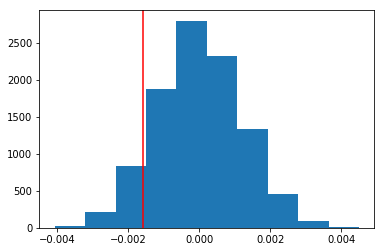

In [36]:
plt.hist(p_diffs)

plt.axvline(sample_mean_diff, color='r');

> **Yes. We can expect normal distributions in case of sampling distribution of difference of means, explained by the Central Limit Theorem.**  

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [37]:
(p_diffs > sample_mean_diff).mean()

0.9027

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

> **In part `j.` I computed the p-value, which measures the probability (proportion / 1) of finding the statistics for the alternative hypothesis, or to the extreme in favor of the alternative hypothesis (in this case greater than the minimum possible statistics), considering that the null hypothesis is true. This means that the chance that the mean parameter of the population ($\mu_{p}$) falls within the null hypothesis, therefore confirming the null, is greater than our stipulated critical value ($\alpha$), which is the maximum probability we are willing to admit in order to reject the null hypothesis.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [38]:
df2[df2['group'] == 'treatment'].shape[0]

145310

In [39]:
import statsmodels.api as sm

convert_old = df2[df2['group'] == 'control'].converted.sum()
convert_new = df2[df2['group'] == 'treatment'].converted.sum()
n_old = df2[df2['group'] == 'control'].shape[0]
n_new = df2[df2['group'] == 'treatment'].shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [40]:
from statsmodels.stats import proportion

In [41]:
zcore, pval = proportion.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')

zcore, pval

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

> **The z-score of value ~ 1.31 means that the value found for sample difference is roughly 1.31 times standard deviations above the mean ($1.31\sigma.\bar{x}$), which confirms the findings of parts `j.` and `k.`,  as shown below through `zcore * p_diffs.std()`, which should be roughly equal to the absolute value of `sample_mean_diff`.**

In [42]:
zcore * p_diffs.std()

0.0015818977282796073

In [43]:
sample_mean_diff

-0.0015782389853555567

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

> **We should be performing a Logistic Regression, given that Logistic Regression is a technique used to predict categorical variables, or variables that have two possible outcomes. In this case, the page either converted or it didn't.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.

In [44]:
df2['intercept'] = 1

df2 = df2.join(pd.get_dummies(df['group']))

In [45]:
df2['ab_page'] = df2['treatment']

df2.drop(columns=['control', 'treatment'], inplace=True)

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [46]:
mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [47]:
results = mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 18 Jun 2019   Pseudo R-squ.:               8.077e-06
Time:                        11:12:45   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**? <br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?


> **The p-value associated with `ab_page` is 0.190 (P > |z|). This happens because the Null Hypothesis and Alternative Hypothesis in the Logistic Regression refer to the probability of existing a relationship between the `ab_page` vaiable and the `converted` variable, which is not the same p-value that we looked for in Part II.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

> **The main advantage of adding variables into the regression model is that it may increase the model's precision, increasing its predictions reliablitiy. On the other hand, adding too many variables to a regression model may cause overfitting, which causes the model to work best for the available data, but fail to predict the future.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?

In [48]:
countries_df = pd.read_csv('./countries.csv')

In [49]:
# merge df2 and countries_df
df2 = pd.merge(countries_df, df2, on='user_id', how='inner')

In [50]:
df2 = df2.join(pd.get_dummies(df2['country']))

In [51]:
mod2 = sm.Logit(df2['converted'], df2[['intercept', 'UK', 'CA']])
results2 = mod2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Tue, 18 Jun 2019   Pseudo R-squ.:               1.521e-05
Time:                        11:12:46   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
==============================================================================
"""

In [52]:
np.exp(results2.params)

intercept    0.135779
UK           1.009966
CA           0.960018
dtype: float64

> **The country does not seem to be relevant to predict the conversion in relation to each other considering the p-values of each dummy variable above (the model consider the relation of `UK` and `CA` with `US`). Also, for each country, it is almost the same as likely as the others (by factor of ~ 1.0) that the new page will convert at a fixed ratio when compared to the old page.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [53]:
# model without interaction

mod3 = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'UK']])
results3 = mod3.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366117
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Tue, 18 Jun 2019   Pseudo R-squ.:               1.233e-05
Time:                        11:12:47   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.2693
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9919      0.009   -228.420      0.000      -2.009      -1.975
ab_page       -0.0150      0.011     -1.309      0.191      -0.037       0.007
UK             0.0126      0.013      0.952      0.341      -0.013       0.038
==============================================================================
"""

In [54]:
np.exp(results3.params)

intercept    0.136432
ab_page      0.985145
UK           1.012632
dtype: float64

In [55]:
df2['UK_ab_page'] = df2['UK']*df2['ab_page']

mod4 = sm.Logit(df2['converted'], df2[['intercept', 'UK_ab_page', 'ab_page', 'UK']])
results4 = mod4.fit()
results4.summary()

Optimization terminated successfully.
         Current function value: 0.366114
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 18 Jun 2019   Pseudo R-squ.:               2.036e-05
Time:                        11:12:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.2278
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9876      0.009   -213.551      0.000      -2.006      -1.969
UK_ab_page     0.0345      0.026      1.307      0.191      -0.017       0.086
ab_page       -0.0236      0.013     -1.788      0.074      -0.050       0.002
UK            -0.0046      0.019     -0.247      0.805      -0.041       0.032
==============================================================================
"""

In [56]:
np.exp(results4.params)

intercept     0.137020
UK_ab_page    1.035055
ab_page       0.976656
UK            0.995418
dtype: float64

> **The analyzed interaction failed to fit a logistic model that could predict the a future value for the conversion of the new website. In other words, the interaction between the variables did not change the interpretation of the coefficients, which stayed about the same.**

<a id='conclusions'></a>
## Conclusions


> **The conclusion of the A/B Test Results is that the new page should not be implemented, as we failed to reject the Null Hypothesis. However, we should consider that A/B tests for webpages may suffer effects such as change aversion. In order for a test to avoid the trap of change aversion, a test has to be ran enough times, or long enough, for the existing users to acclimate with the change. A time delta of 21 days for this specific test might not be enough (proof of the timedelta below). I would argue that, since there wouldn't be a problem to maintain the A/B test for longer than 21 days, I would keep it running for another month and would check the results again. If then we are able to reject the null hypothesis, then we implement the new site. Otherwise, we keep the old site as there are no reasons for spending resources in a change that has not been scientifically proven to be effective going through a change.**

In [57]:
# set timestamp to datetime and get the largest timedelta

df2['timestamp'] = pd.to_datetime(df2['timestamp'])

df2['timestamp'].max() - df2['timestamp'].min()

Timedelta('21 days 23:59:49.081927')